In [4]:
from wandb.integration.keras import WandbMetricsLogger
from mlp_explainer import explainer, metrics
from scikeras.wrappers import KerasClassifier
from pgmpy.utils import get_example_model
from tensorflow import keras
import mlp_explainer
import numpy as np
import sklearn
import wandb
import copy

In [5]:
wandb.login()

True

In [6]:
from ucimlrepo import fetch_ucirepo 
  
car_evaluation = fetch_ucirepo(id = 19) 

X = car_evaluation.data.features.to_numpy()
y = car_evaluation.data.targets.to_numpy()

  0%|          | 0/37 [00:00<?, ?it/s]

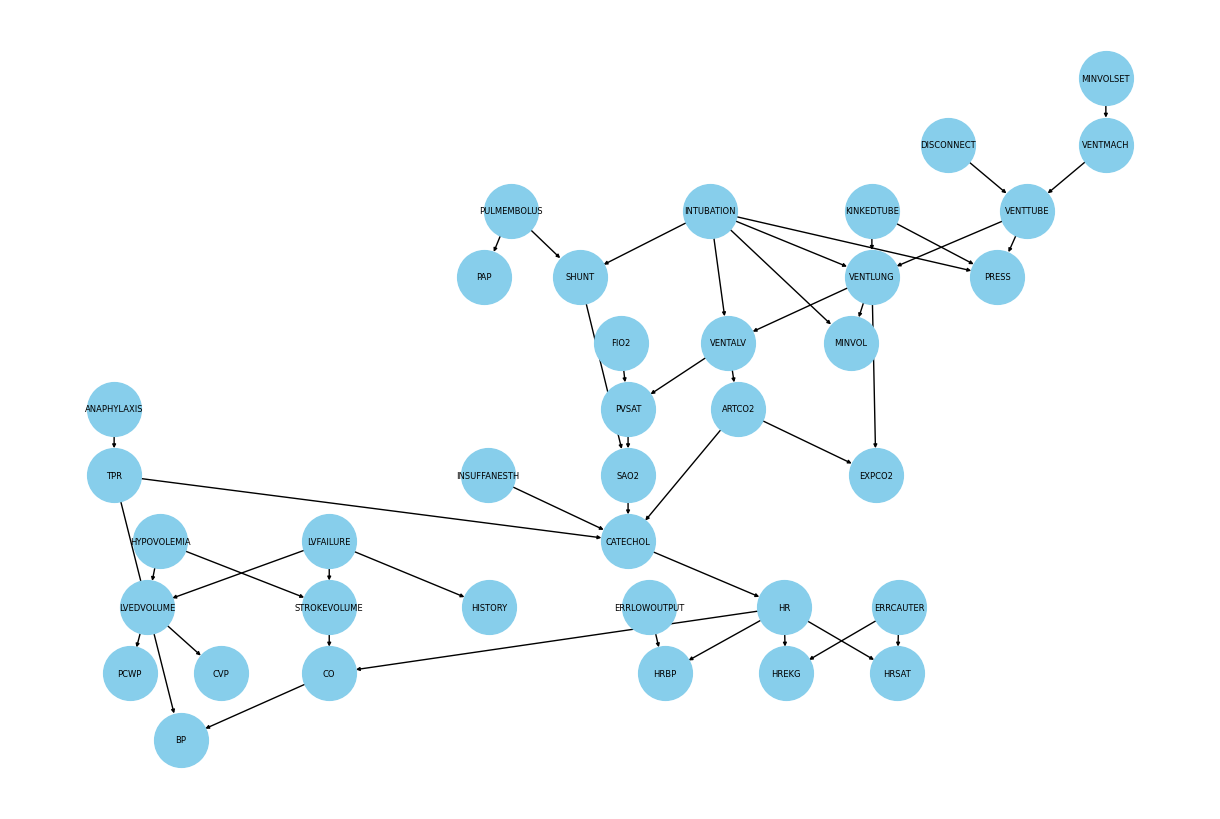

In [456]:
ground_bn = get_example_model("alarm")
dataset = ground_bn.simulate(n_samples = 1000)[['CATECHOL', 'HR', 'HRBP', 'HREKG', 'HRSAT', 'ERRCAUTER', 'ERRLOWOUTPUT', 'CO']]

X = dataset.drop('HR', axis = 1).to_numpy()
y = dataset['HR'].to_numpy()

metrics.draw_network(ground_bn)

In [457]:
def build_model(input_shape, classes, n_layers = 5, n_nodes_l = 2, n_nodes_u = 10, optimizer = 'adam', learning_rate = 0.001):
    
    model = keras.Sequential()
    model.add(keras.Input(shape = (input_shape,)))
    for i in range(n_layers):
        model.add(keras.layers.Dense(np.random.choice([i for i in range(n_nodes_l, n_nodes_u)]), activation = np.random.choice(['relu', 'sigmoid'])))
    model.add(keras.layers.Dense(classes, activation = 'softmax'))

    if optimizer == 'sgd':
        optim = keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'adam':
        optim = keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [458]:
n_layers = 5
n_nodes_l = 5
n_nodes_u = 50
optimizer = 'adam'
learning_rate = 0.01
epochs = 25
batch_size = 64

In [459]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size = 0.1, random_state = 42, shuffle = True
)

In [460]:
feature_encoder = sklearn.preprocessing.OrdinalEncoder()
feature_encoder.fit(X_train)

target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(y_train.squeeze())

LabelEncoder()

In [461]:
X_train_proc = feature_encoder.transform(X_train)
y_train_proc = target_encoder.transform(y_train)

In [462]:
n_classes = len(np.unique(y))
input_shape = len(X[0])

In [463]:
#wandb.init(entity = "computer-vision-wits", project = "MLP-E", name = "")
    
model = build_model(
    input_shape,
    n_classes,
    n_layers = n_layers, 
    n_nodes_l = n_nodes_l,
    n_nodes_u = n_nodes_u, 
    optimizer = optimizer, 
    learning_rate = learning_rate
)

'''
config = wandb.config
config.n_layers = n_layers
config.n_nodes_l = n_nodes_l
config.n_nodes_u = n_nodes_u
config.optimizer = optimizer
config.epochs = epochs
config.batch_size = batch_size
config.learning_rate = learning_rate
'''

model.fit(X_train_proc, y_train_proc, epochs = epochs, batch_size = batch_size, validation_split = 0.2)
model.summary()

#wandb.finish()

Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7806 - loss: 0.6532 - val_accuracy: 0.8389 - val_loss: 0.5075
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8347 - loss: 0.5076 - val_accuracy: 0.8389 - val_loss: 0.4967
Epoch 3/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8347 - loss: 0.4991 - val_accuracy: 0.8389 - val_loss: 0.4994
Epoch 4/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8347 - loss: 0.4980 - val_accuracy: 0.8389 - val_loss: 0.4971
Epoch 5/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8347 - loss: 0.4977 - val_accuracy: 0.8389 - val_loss: 0.4957
Epoch 6/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8347 - loss: 0.4968 - val_accuracy: 0.8389 - val_loss: 0.4968
Epoch 7/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8347 - loss: 0.4968 - val_accuracy: 0.8389 - val_loss: 0.4955
Epoch 8/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8347 - loss: 0.4967 - val_accuracy: 0.8389 - val_loss

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 24)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 48)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 28)             │         1,372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 44)             │         1,276 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 13)             │           585 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 3)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,003 (54.70 KB)

 Trainable params: 4,667 (18.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,336 (36.47 KB)

In [464]:
X_test_proc = feature_encoder.transform(X_test)
y_test_proc = target_encoder.transform(y_test)

y_pred = model(X_test_proc)
y_pred = np.argmax(y_pred, axis = 1)
sklearn.metrics.accuracy_score(y_pred, y_test_proc)

0.95

In [465]:
import numpy as np
import pandas as pd
from pgmpy.estimators import PC
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

class Explainer:
    def __init__(self, model, X, preprocessor, n_samples = 100, rep_prob = 0.5):

        '''
        Args:
            model: model
            X: dataframe of X data (training, testing or all)
            preprocessor: function used to preprocess data prior to model forward pass
            n_samples: number of samples to generate for a single prediction explanation
            rep_prob: probability at which each feature value of x datapoint should be replaced with a value from a sample
        '''

        self.model = model
        self.X = X.to_numpy()
        self.preprocessor = preprocessor
        self.x_cols = X.columns
        self.y_col = 'target'
        self.n_samples = n_samples
        self.rep_prob = rep_prob
        
        self.data = None
        self.patterns = []
        self.relevance_dict = {col: 0 for col in self.x_cols}

    def __init_structures(self):
        self.data = None
        self.patterns = []
        
    def __data_generation(self, x: np.ndarray):

        y = self.model.predict(self.preprocessor(x.reshape(1, -1)), verbose=0).squeeze(0)
        y_argmax = y.argmax()
        
        random_indices = np.random.randint(len(self.X), size=self.n_samples)
        samples_X_base = self.X[random_indices]
        
        replace_mask = np.random.rand(self.n_samples, samples_X_base.shape[1]) < self.rep_prob
        
        samples_X_generated = np.where(replace_mask, x, samples_X_base)
        
        preprocessed_batch = self.preprocessor(samples_X_generated)
        
        samples_Y_raw = self.model.predict(preprocessed_batch, verbose=0)
        
        samples_Y_argmax = samples_Y_raw.argmax(axis=1)
        
        samples_Y_bool = samples_Y_argmax != y_argmax
        
        samples_X_bool = samples_X_generated != x
        
        samples_X_int = samples_X_bool.astype(int)
        samples_Y_int = samples_Y_bool.astype(int)
        
        self.data = pd.DataFrame(samples_X_int, columns=self.x_cols)
        self.data[self.y_col] = samples_Y_int


    def fp_growth(self, data, class_):

        data = data.to_numpy()
        
        encoder = TransactionEncoder()
        encoded = encoder.fit(data).transform(data)
        
        data = pd.DataFrame(encoded, columns = encoder.columns_)

        class_patterns = fpgrowth(data, min_support = 0.3, use_colnames = True)
        
        self.patterns.append(class_patterns)

    def _harmonic_merge(self):

        self.patterns[0] = self.patterns[0].rename(columns = {'support': 'support_stable'})
        self.patterns[1] = self.patterns[1].rename(columns = {'support': 'support_unstable'})
        
        patterns_merged = pd.merge(
            self.patterns[0],
            self.patterns[1],
            on = 'itemsets',
            how = 'outer'
        )
        
        patterns_merged = patterns_merged.fillna(0)
        
        support_0 = patterns_merged['support_stable']
        support_1 = patterns_merged['support_unstable']

        denominator = support_0 + support_1
        patterns_merged['Harmonic Mean'] = (2 * support_0 * support_1 / denominator).mask(denominator == 0, 0)
        
        harmonic_rank = patterns_merged[['itemsets', 'support_stable', 'support_unstable', 'Harmonic Mean']].sort_values(
            by = 'Harmonic Mean', 
            ascending = False
        )
        
        return harmonic_rank[harmonic_rank['Harmonic Mean'] > 0.0]

    def __relevance_rank(self):

        rank = self.__harmonic_merge()

        for row, idx in rank.iterrows():
    
            features = tuple(idx['itemsets'])
            h_mean = idx['Harmonic Mean']
            n_features = len(features)
            
            for feature in features:
                self.relevance_dict[feature] += h_mean / n_features

    def forward(self, x) -> None:

        self.__init_structures()
        
        self.__data_generation(x)
        print('I')
        
        for class_ in [0, 1]:
            
            class_data = self.data.loc[self.data[self.y_col] == class_]
            class_data = class_data.drop(self.y_col, axis = 1)
            
            for i, col in enumerate(class_data.columns):
                class_data[col] = np.where(class_data[col] == 0, i + 1, -(i + 1))
                
            self.fp_growth(class_data, class_)
            print('II')
        
        #self.__relevance_rank()

In [467]:
x_cols = list(dataset.drop('HR', axis = 1).columns)
y_col = 'HR'

def preprocessor(x):
    return feature_encoder.transform(x)

In [555]:
explainer = Explainer(
    model = model,
    X = dataset.drop(y_col, axis = 1),
    preprocessor = preprocessor,
    n_samples = 1000,
    rep_prob = 0.1
)

In [556]:
for _ in range(1):
    x = X_test[np.random.randint(len(X_test))]
    explainer.forward(x)

I
II
II


In [557]:
len(explainer.data[explainer.data['target'] == 1].to_numpy())

792

In [558]:
dataset.drop('HR', axis = 1).columns

Index(['CATECHOL', 'HRBP', 'HREKG', 'HRSAT', 'ERRCAUTER', 'ERRLOWOUTPUT',
       'CO'],
      dtype='object')

In [564]:
a = explainer.patterns[0].sort_values(by = 'support', ascending = False)
b = explainer.patterns[1].sort_values(by = 'support', ascending = False)

In [567]:
import pandas as pd

def partial_flip_matches(stable_df, unstable_df):
    """
    Compare FP-growth results from stable and unstable groups 
    to find conditionally significant feature configurations.

    Each itemset is a set of signed integers:
        +i means feature i unchanged
        -i means feature i changed
    """
    matches = []

    for _, row_s in stable_df.iterrows():
        stable_set = row_s['itemsets']
        abs_stable = {abs(x) for x in stable_set}

        for _, row_u in unstable_df.iterrows():
            unstable_set = row_u['itemsets']
            abs_unstable = {abs(x) for x in unstable_set}

            # condition 1: same absolute feature ids
            if abs_stable == abs_unstable:
                # condition 2: at least one sign difference
                if any((x in stable_set) != (x in unstable_set) and (-x in unstable_set or -x in stable_set)
                       for x in abs_stable):
                    matches.append({
                        'features': abs_stable,
                        'stable_pattern': tuple(sorted(stable_set)),
                        'unstable_pattern': tuple(sorted(unstable_set)),
                        'stable_support': row_s['support'],
                        'unstable_support': row_u['support']
                    })

    return pd.DataFrame(matches)


In [569]:
dataset.drop('HR', axis = 1).columns

Index(['CATECHOL', 'HRBP', 'HREKG', 'HRSAT', 'ERRCAUTER', 'ERRLOWOUTPUT',
       'CO'],
      dtype='object')

In [577]:
c = partial_flip_matches(a, b)

support_0 = c['stable_support']
support_1 = c['unstable_support']

denominator = support_0 + support_1
c['Harmonic Mean'] = (2 * support_0 * support_1 / denominator).mask(denominator == 0, 0)

c.sort_values(by = 'Harmonic Mean', ascending = False).head(50)

,features,stable_pattern,unstable_pattern,stable_support,unstable_support,Harmonic Mean
2,{3},"(3,)","(-3,)",0.788462,0.912879,0.846121
1,{4},"(4,)","(-4,)",0.793269,0.896465,0.841716
0,{2},"(2,)","(-2,)",0.812500,0.859848,0.835504
4,"{2, 6}","(2, 6)","(-2, 6)",0.778846,0.824495,0.801021
11,"{3, 6}","(3, 6)","(-3, 6)",0.725962,0.880051,0.795614
3,"{4, 5}","(4, 5)","(-4, 5)",0.778846,0.810606,0.794409
7,"{4, 6}","(4, 6)","(-4, 6)",0.735577,0.861111,0.793409
5,"{3, 5}","(3, 5)","(-3, 5)",0.754808,0.829545,0.790414
9,"{3, 4}","(3, 4)","(-4, -3)",0.725962,0.815657,0.768200
6,"{2, 5}","(2, 5)","(-2, 5)",0.745192,0.779040,0.761741


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'CATECHOL': 'C', 'HRBP': 'C', 'HREKG': 'C', 'HRSAT': 'C', 'ERRCAUTER': 'C', 'ERRLOWOUTPUT': 'C', 'CO': 'C', 'target': 'C'}


  0%|          | 0/5 [00:00<?, ?it/s]

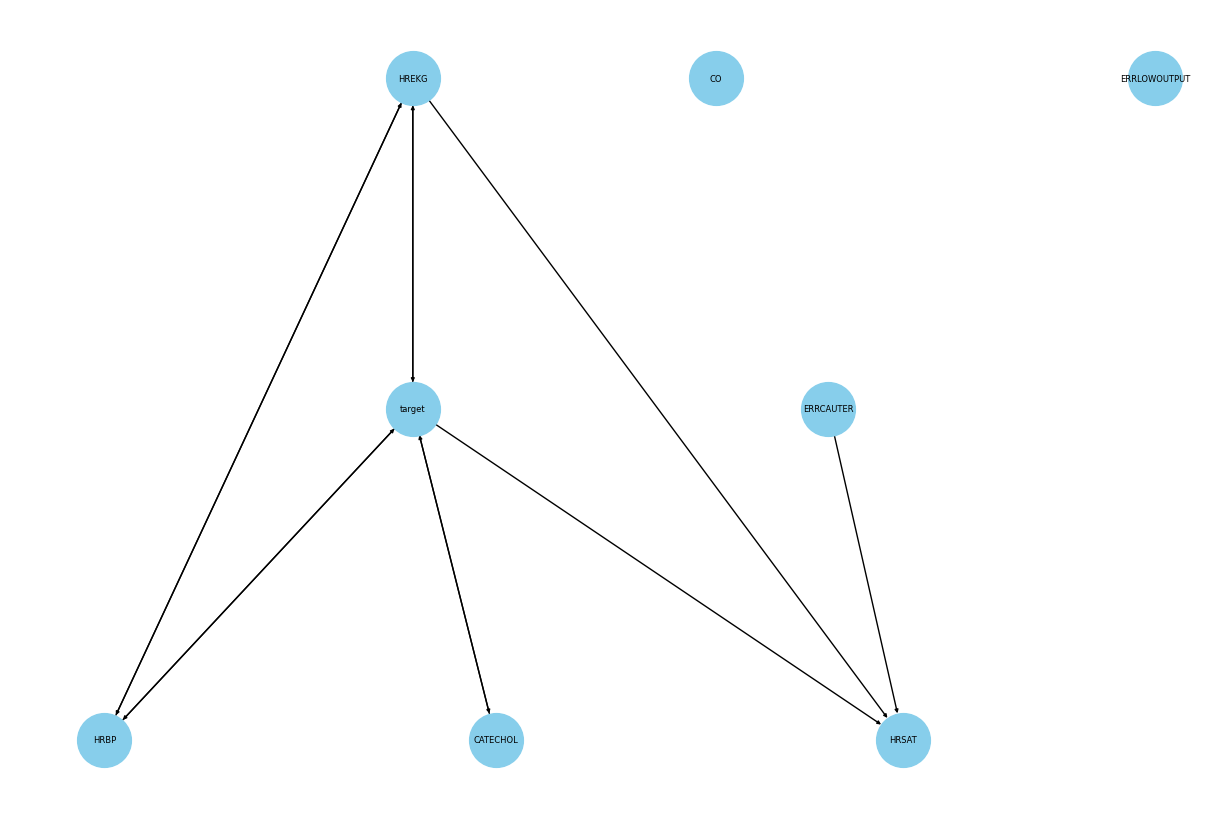

In [572]:
data = explainer.data.astype(str)

est = PC(data = data)

model_chi = est.estimate(ci_test = "chi_square")
metrics.draw_network(model_chi)